In [1]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD 
from sklearn.preprocessing import normalize 
import nltk.stem.porter
porter_stemmer=nltk.stem.porter.PorterStemmer()
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 
import nltk
from sklearn.metrics.pairwise import linear_kernel

from pathlib import Path

nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /home/miguel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/miguel/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

#### PREPROCESSING

In [2]:
#This function will extract raw message from the message object
def raw_message(raw_message):
    lines = raw_message.split('\n') #Here, the paragraph contains "\n" indicating the new line. Hence, the sentence tokenizer is not used.
    email = {}
    message = ''
    keys_to_extract = ['from', 'to']
    for line in lines:
        if ':' not in line:
            message += line.strip() #removes all the spaces and appends only the text body to the variable "message"
            email['body'] = message
        else:
            pairs = line.split(':') #This enables to divide each sentence into 2 parts
            key = pairs[0].lower()
            val = pairs[1].strip()
            if key in keys_to_extract:
                email[key] = val
    return email  #returns an array with key-value pairs

In [3]:
def parse_into_emails(messages):
    emails = [raw_message(message) for message in messages]
    return {
        'body': map_to_list(emails, 'body'), 
        'to': map_to_list(emails, 'to'), 
        'from_': map_to_list(emails, 'from')
    }

In [4]:
def map_to_list(emails, key):
    results = []
    for email in emails:
        if key not in email:
            results.append('')
        else:
            results.append(email[key])
    return results

In [5]:
def top_feats_in_doc(X, features, row_id, top_n=25):
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [6]:
def top_tfidf_feats(row, features, top_n=20):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df

In [7]:
data_dir = Path(Path.cwd().parent, 'data')

In [8]:
#reading the dataset
# emails1 = pd.read_csv(Path(data_dir, 'interim/split_emails.csv'))
emails = pd.read_csv(Path(data_dir,'raw/emails.csv'))


In [9]:
large_emails = emails.message.apply(len).sort_values(ascending=False).head(6).index
emails = emails.loc[~emails.index.isin(large_emails)]
emails=emails[:15000]
# emails=emails[:200000]

In [10]:
#creating a dataframe
email_df = pd.DataFrame(parse_into_emails(emails.message))


In [11]:
email_df.head()

,body,to,from_
0,Here is our forecast,tim.belden@enron.com,phillip.allen@enron.com
1,Traveling to have a business meeting takes the...,john.lavorato@enron.com,phillip.allen@enron.com
2,test successful. way to go!!!,leah.arsdall@enron.com,phillip.allen@enron.com
3,"Randy,Can you send me a schedule of the salary...",randall.gay@enron.com,phillip.allen@enron.com
4,,greg.piper@enron.com,phillip.allen@enron.com


In [12]:
# Drop emails with empty body, to or from_ columns.
email_df.drop(email_df.query("body == '' | to == '' | from_ == ''").index, inplace=True)

In [13]:
#finding top words
stopwords = ENGLISH_STOP_WORDS.union(['ect', 'hou', 'com', 'recipient'])
vect = TfidfVectorizer(analyzer='word', stop_words=stopwords, max_df=0.3, min_df=2)
# max_df=0.5 means "ignore all terms that appear in more then 50% of the documents"
# min_df=2 means "ignore all terms that appear in less then 2 documents"

In [14]:
email_df.head()

,body,to,from_
0,Here is our forecast,tim.belden@enron.com,phillip.allen@enron.com
1,Traveling to have a business meeting takes the...,john.lavorato@enron.com,phillip.allen@enron.com
2,test successful. way to go!!!,leah.arsdall@enron.com,phillip.allen@enron.com
3,"Randy,Can you send me a schedule of the salary...",randall.gay@enron.com,phillip.allen@enron.com
5,"Greg,How about either next Tuesday or Thursday...",greg.piper@enron.com,phillip.allen@enron.com


In [15]:
#stemming
body = email_df.body
def stemmingDF(body):
    bigl=[]
    for string in body:
        lis=string.split()
        l=[]
        for word in lis:
            if word.isalpha()==True:                
                if word not in stopwords:
                    if len(word)!=1:
                        word=word.lower()
                        word=lemmatizer.lemmatize(word)
                        l.append(word)
        str1=' '.join(l)
        bigl.append(str1)
    return bigl

email_df["body_new"] = stemmingDF(body)

In [16]:
email_df.head()

,body,to,from_,body_new
0,Here is our forecast,tim.belden@enron.com,phillip.allen@enron.com,here forecast
1,Traveling to have a business meeting takes the...,john.lavorato@enron.com,phillip.allen@enron.com,traveling business meeting take fun especially...
2,test successful. way to go!!!,leah.arsdall@enron.com,phillip.allen@enron.com,test way
3,"Randy,Can you send me a schedule of the salary...",randall.gay@enron.com,phillip.allen@enron.com,send schedule salary level thescheduling plus ...
5,"Greg,How about either next Tuesday or Thursday...",greg.piper@enron.com,phillip.allen@enron.com,tuesday


In [17]:
# print top features
X = vect.fit_transform(email_df.body_new)
features = vect.get_feature_names_out()
print(top_feats_in_doc(X, features, 1, 20))

      features     score
0     business  0.355043
1      meeting  0.269461
2         trip  0.241425
3   discussion  0.231419
4    stimulate  0.193768
5          try  0.192422
6    presenter  0.191078
7       speaks  0.176552
8      desired  0.170664
9       honest  0.170664
10       quiet  0.168676
11  productive  0.164354
12        boat  0.161403
13   traveling  0.152845
14      flying  0.151461
15        golf  0.145921
16         ski  0.144890
17     prepare  0.139263
18     suggest  0.138743
19  suggestion  0.138743


/home/miguel/anaconda3/envs/tfm/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/miguel/anaconda3/envs/tfm/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/miguel/anaconda3/envs/tfm/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html


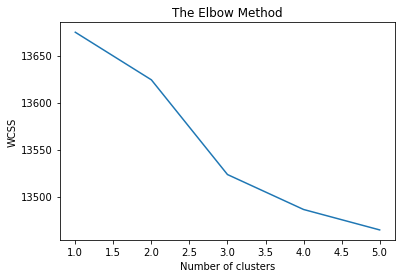

In [18]:
#kmeans clustering

wcss = []
for i in range(1, 6):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X.todense())
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 6), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [19]:
n_clusters = 4
clf = KMeans(n_clusters=n_clusters, 
            max_iter=100, 
            init='k-means++', 
            n_init=1)
labels = clf.fit_predict(X)

In [20]:
def plot_tfidf_classfeats_h(dfs):
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("cluster = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#7530FF')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.features)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()


In [21]:
def top_feats_per_cluster(X, y, features, min_tfidf=0.1, top_n=25):
    dfs = []

    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label) 
        feats_df = top_mean_feats(X, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [22]:
def top_mean_feats(X, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    if grp_ids:
        D = X[grp_ids].toarray()
    else:
        D = X.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

/home/miguel/anaconda3/envs/tfm/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/miguel/anaconda3/envs/tfm/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


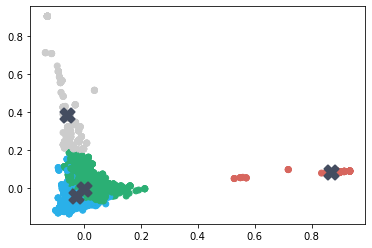

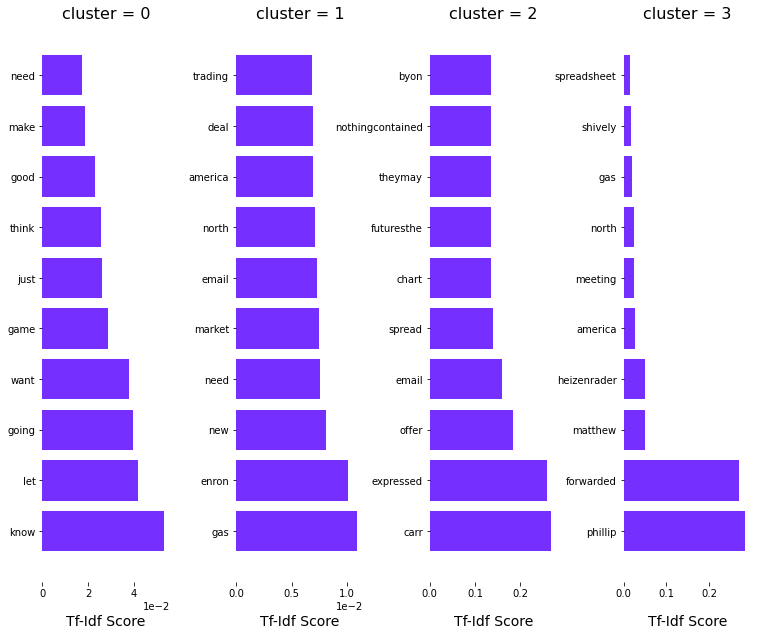

In [23]:
X_dense = X.todense()
pca = PCA(n_components=2).fit(X_dense)
coords = pca.transform(X_dense)

# Lets plot it again, but this time we add some color to it.
# This array needs to be at least the length of the n_clusters.
label_colors = ["#2AB0E9", "#2BAF74", "#D7665E", "#CCCCCC", 
                "#D2CA0D", "#522A64", "#A3DB05", "#FC6514"]
colors = [label_colors[i] for i in labels]

plt.scatter(coords[:, 0], coords[:, 1], c=colors)
# Plot the cluster centers
centroids = clf.cluster_centers_
centroid_coords = pca.transform(centroids)
plt.scatter(centroid_coords[:, 0], centroid_coords[:, 1], marker='X', s=200, linewidths=2, c='#444d60')
plt.show()

#Use this to print the top terms per cluster with matplotlib.
plot_tfidf_classfeats_h(top_feats_per_cluster(X, labels, features, 0.1, 10))

In [24]:
def cos_score(lst):   
    leve_m=np.zeros([10,10])
    for i,word1 in enumerate(lst['features']):
        for j,word2 in enumerate(lst['features']):
            if word1!=word2:
                leve_m[i][j]=linear_kernel(lst['score'][i].reshape(-1,1),lst['score'][j].reshape(-1,1)).flatten()
    return leve_m.mean()

In [25]:
lst0=top_feats_per_cluster(X,labels,features,0.1,10)[0]
lst1=top_feats_per_cluster(X,labels,features,0.1,10)[1]
lst2=top_feats_per_cluster(X,labels,features,0.1,10)[2]

In [26]:
score0=cos_score(lst0)
score1=cos_score(lst1)
score2=cos_score(lst2)

In [27]:
print(score0)
print(score1)
print(score2)

0.0008635712037555249
5.63862461477874e-05
0.02555940854483489


In [28]:
X_new=X.todense()
from scipy.cluster import hierarchy
Z=hierarchy.linkage(X_new, 'ward')

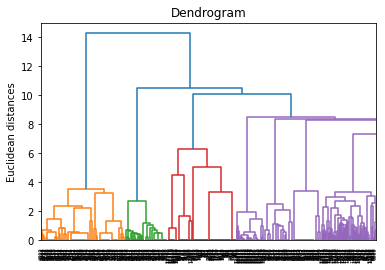

In [29]:
dn = hierarchy.dendrogram(Z)
#dendrogram=sch.dendrogram(sch,linkage(X,method='ward'))
plt.title('Dendrogram')
#plt.xlabel('Customers')
plt.ylabel('Euclidean distances')

plt.xlim(0,5000)
plt.ylim(0,15)
plt.show()


In [30]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(X_new)

/home/miguel/anaconda3/envs/tfm/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [31]:
y_hc1=y_hc.astype(np.int32)

In [32]:
from sklearn.metrics.pairwise import linear_kernel
def cos_score(lst):   
    leve_m=np.zeros([10,10])
    for i,word1 in enumerate(lst['features']):
        for j,word2 in enumerate(lst['features']):
            if word1!=word2:
                leve_m[i][j]=linear_kernel(lst['score'][i].reshape(-1,1),lst['score'][j].reshape(-1,1)).flatten()
    return leve_m.mean()

In [33]:
lst0=top_feats_per_cluster(X,y_hc1,features,0.1,10)[0]
lst1=top_feats_per_cluster(X,y_hc1,features,0.1,10)[1]
lst2=top_feats_per_cluster(X,y_hc1,features,0.1,10)[2]
lst3=top_feats_per_cluster(X,y_hc1,features,0.1,10)[3]

In [34]:
score0=cos_score(lst0)
    
score1=cos_score(lst1)
score2=cos_score(lst2)
score3=cos_score(lst3)

In [35]:
print(score0)
print(score1)
print(score2)
print(score3)

8.102283857295646e-05
0.020549867362868818
0.041901601658993134
0.02555940854483489
